In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

In [42]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dailyActivity_merged.csv')
df.head(90)

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,3/25/2016,11004,7.11,7.11,0.0,2.57,0.46,4.07,0.0,33,12,205,804,1819
1,1503960366,3/26/2016,17609,11.55,11.55,0.0,6.92,0.73,3.91,0.0,89,17,274,588,2154
2,1503960366,3/27/2016,12736,8.53,8.53,0.0,4.66,0.16,3.71,0.0,56,5,268,605,1944
3,1503960366,3/28/2016,13231,8.93,8.93,0.0,3.19,0.79,4.95,0.0,39,20,224,1080,1932
4,1503960366,3/29/2016,12041,7.85,7.85,0.0,2.16,1.09,4.61,0.0,28,28,243,763,1886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2026352035,4/2/2016,1229,0.76,0.76,0.0,0.00,0.00,0.76,0.0,0,0,69,795,1237
86,2026352035,4/3/2016,2308,1.43,1.43,0.0,0.00,0.00,1.43,0.0,0,0,115,720,1330
87,2026352035,4/4/2016,6679,4.14,4.14,0.0,0.00,0.00,4.14,0.0,0,0,263,644,1583
88,2026352035,4/5/2016,5645,3.50,3.50,0.0,0.00,0.00,3.50,0.0,0,0,248,621,1538


In [43]:
# Convert date column
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'])

In [44]:
# Sort by date
df = df.sort_values('ActivityDate')

In [45]:
# 2. Rule-Based Anomaly Detection (Threshold)

mean_steps = df['TotalSteps'].mean()
std_steps = df['TotalSteps'].std()

upper_threshold = mean_steps + 3 * std_steps
lower_threshold = mean_steps - 3 * std_steps

df['threshold_anomaly'] = (
    (df['TotalSteps'] > upper_threshold) |
    (df['TotalSteps'] < lower_threshold)
)

In [46]:
# 3. Clustering-Based Anomaly Detection (KMeans)

X = df[['TotalSteps']].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Distance from cluster centers
centers = kmeans.cluster_centers_
distances = np.linalg.norm(X_scaled - centers[df['cluster']], axis=1)

# Mark top 5% farthest points as anomalies
distance_threshold = np.percentile(distances, 95)
df['cluster_anomaly'] = distances > distance_threshold

In [47]:
# 4. Prophet Residual-Based Anomaly Detection

prophet_df = df[['ActivityDate', 'TotalSteps']]
prophet_df.columns = ['ds', 'y']

model = Prophet(daily_seasonality=False)
model.fit(prophet_df)

forecast = model.predict(prophet_df)

# Residuals
df['residual'] = prophet_df['y'] - forecast['yhat']

residual_threshold = 3 * df['residual'].std()
df['prophet_anomaly'] = abs(df['residual']) > residual_threshold

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [48]:
# 5. Combine All Anomalies

df['final_anomaly'] = (
    df['threshold_anomaly'] |
    df['cluster_anomaly'] |
    df['prophet_anomaly']
)

print("\nSample detected anomalies:")
print(df[df['final_anomaly']].head())


Sample detected anomalies:
             Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
251  4445114986   2016-03-31        4804           3.22             3.22   
445  8877689391   2016-04-01       18700          15.82            15.82   
366  7007744171   2016-04-01       11680           9.06             7.81   
378  7086361926   2016-04-01       11463           7.67             7.67   
390  8053475328   2016-04-02       20188          15.62            15.62   

     LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
251                  0.000000                0.00                      0.00   
445                  0.000000                8.70                      0.16   
366                  4.901283                4.49                      0.33   
378                  0.000000                2.83                      1.89   
390                  0.000000               12.06                      0.85   

     LightActiveDistance  SedentaryActiv

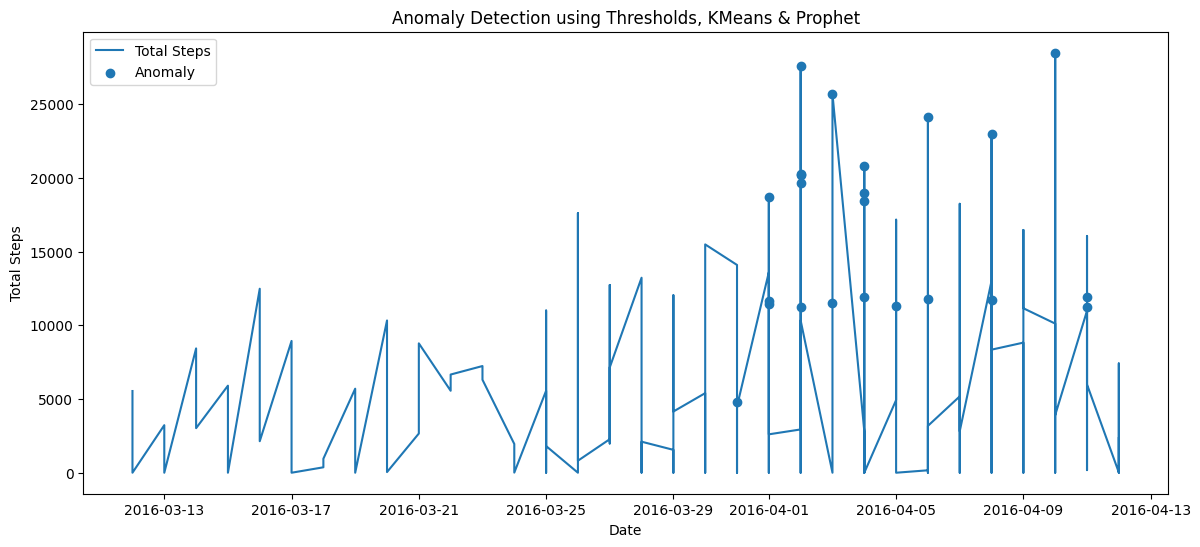

In [49]:
# 6. Visualization (Matplotlib)

plt.figure(figsize=(14, 6))
plt.plot(df['ActivityDate'], df['TotalSteps'], label='Total Steps')
plt.scatter(
    df[df['final_anomaly']]['ActivityDate'],
    df[df['final_anomaly']]['TotalSteps'],
    label='Anomaly'
)
plt.xlabel("Date")
plt.ylabel("Total Steps")
plt.title("Anomaly Detection using Thresholds, KMeans & Prophet")
plt.legend()
plt.show()

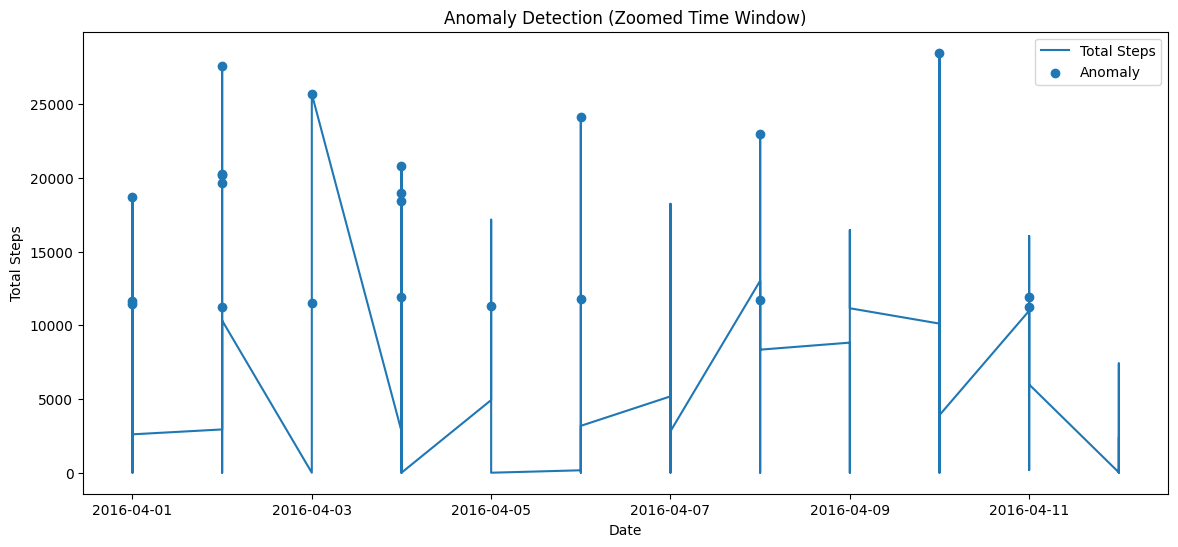

In [50]:
# 7. Time Window Visualization (Optional)

window_df = df[
    (df['ActivityDate'] >= '2016-04-01') &
    (df['ActivityDate'] <= '2016-04-15')
]

plt.figure(figsize=(14, 6))
plt.plot(window_df['ActivityDate'], window_df['TotalSteps'], label='Total Steps')
plt.scatter(
    window_df[window_df['final_anomaly']]['ActivityDate'],
    window_df[window_df['final_anomaly']]['TotalSteps'],
    label='Anomaly'
)
plt.xlabel("Date")
plt.ylabel("Total Steps")
plt.title("Anomaly Detection (Zoomed Time Window)")
plt.legend()
plt.show()